<a href="https://colab.research.google.com/github/Jayalakshmi-27-05/Bioinformatics_lab/blob/main/1RV23BT031_EXP_10_Design_and_Execute_Cloud_Based_Workflow_for_annotation_of_Genome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install required tools
!apt-get install -y prodigal
!pip install biopython matplotlib seaborn pandas

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  prodigal
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 640 kB of archives.
After this operation, 12.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 prodigal amd64 1:2.6.3-5 [640 kB]
Fetched 640 kB in 1s (609 kB/s)
Selecting previously unselected package prodigal.
(Reading database ... 118031 files and directories currently installed.)
Preparing to unpack .../prodigal_1%3a2.6.3-5_amd64.deb ...
Unpacking prodigal (1:2.6.3-5) ...
Setting up prodigal (1:2.6.3-5) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.5 MB/s eta 0:00:00


In [19]:
from google.colab import files
uploaded = files.upload()

Saving sequence(1).fasta to sequence(1) (1).fasta


In [20]:
from Bio import SeqIO

record = SeqIO.read("sequence(1).fasta", "fasta")

genome_length = len(record.seq)
gc_content = 100 * float(record.seq.count("G") + record.seq.count("C")) / genome_length

print("Genome ID:", record.id)
print("Genome length:", genome_length)
print("GC content (%):", round(gc_content, 2))


Genome ID: CP097882.1
Genome length: 4675188
GC content (%): 50.79


In [24]:
!prodigal -i "sequence(1).fasta" -a proteins.faa -d genes.fna -o prodigal.gbk -f gbk

-------------------------------------
PRODIGAL v2.6.3 [February, 2016]         
Univ of Tenn / Oak Ridge National Lab
Doug Hyatt, Loren Hauser, et al.     
-------------------------------------
Request:  Single Genome, Phase:  Training
Reading in the sequence(s) to train...4675188 bp seq created, 50.79 pct GC
Locating all potential starts and stops...242572 nodes
Looking for GC bias in different frames...frame bias scores: 1.54 0.19 1.27
Building initial set of genes to train from...done!
Creating coding model and scoring nodes...done!
Examining upstream regions and training starts...done!
-------------------------------------
Request:  Single Genome, Phase:  Gene Finding
Finding genes in sequence #1 (4675188 bp)...done!


In [25]:
from Bio import SeqIO

gene_count = sum(1 for _ in SeqIO.parse("genes.fna", "fasta"))
protein_count = sum(1 for _ in SeqIO.parse("proteins.faa", "fasta"))

print("Predicted genes:", gene_count)
print("Predicted proteins:", protein_count)


Predicted genes: 4361
Predicted proteins: 4361


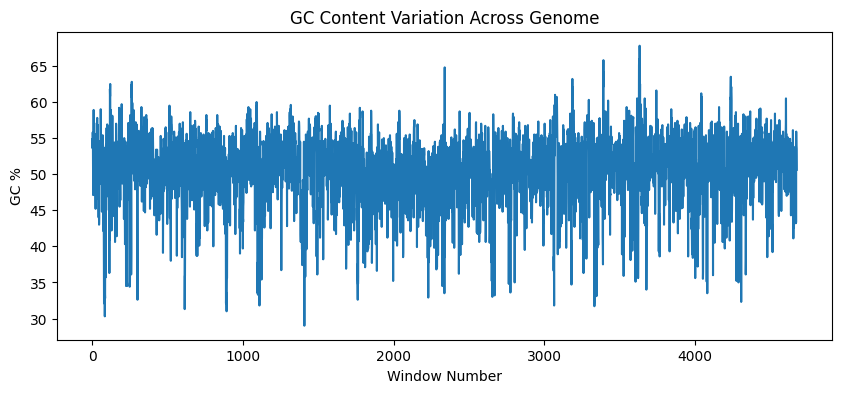

In [26]:
import matplotlib.pyplot as plt

window = 1000
gc_values = []

seq = str(record.seq)

for i in range(0, len(seq) - window, window):
    fragment = seq[i:i+window]
    gc = 100 * (fragment.count("G") + fragment.count("C")) / window
    gc_values.append(gc)

plt.figure(figsize=(10,4))
plt.plot(gc_values)
plt.xlabel("Window Number")
plt.ylabel("GC %")
plt.title("GC Content Variation Across Genome")
plt.show()


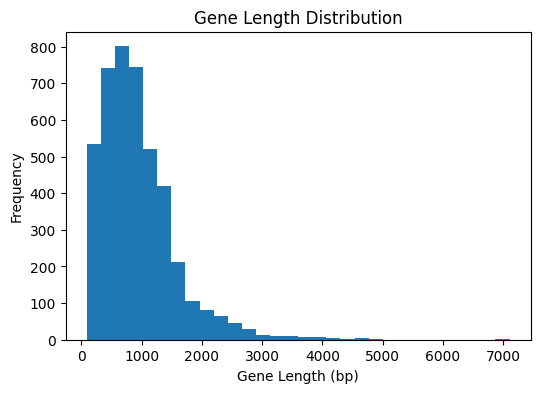

In [27]:
gene_lengths = [len(rec.seq) for rec in SeqIO.parse("genes.fna", "fasta")]

plt.figure(figsize=(6,4))
plt.hist(gene_lengths, bins=30)
plt.xlabel("Gene Length (bp)")
plt.ylabel("Frequency")
plt.title("Gene Length Distribution")
plt.show()


In [28]:
!apt-get install -y ncbi-blast+

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ncbi-blast+ is already the newest version (2.12.0+ds-3build1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [29]:
!blastp -query proteins.faa -db swissprot -out annotations.txt -evalue 1e-5 -outfmt 6

BLAST Database error: No alias or index file found for protein database [swissprot] in search path [/content::]


In [30]:
import pandas as pd

summary = {
    "Genome Length (bp)": genome_length,
    "GC Content (%)": round(gc_content, 2),
    "Number of Genes": gene_count,
    "Number of Proteins": protein_count
}

pd.DataFrame(summary, index=[0])

,Genome Length (bp),GC Content (%),Number of Genes,Number of Proteins
0,4675188,50.79,4361,4361


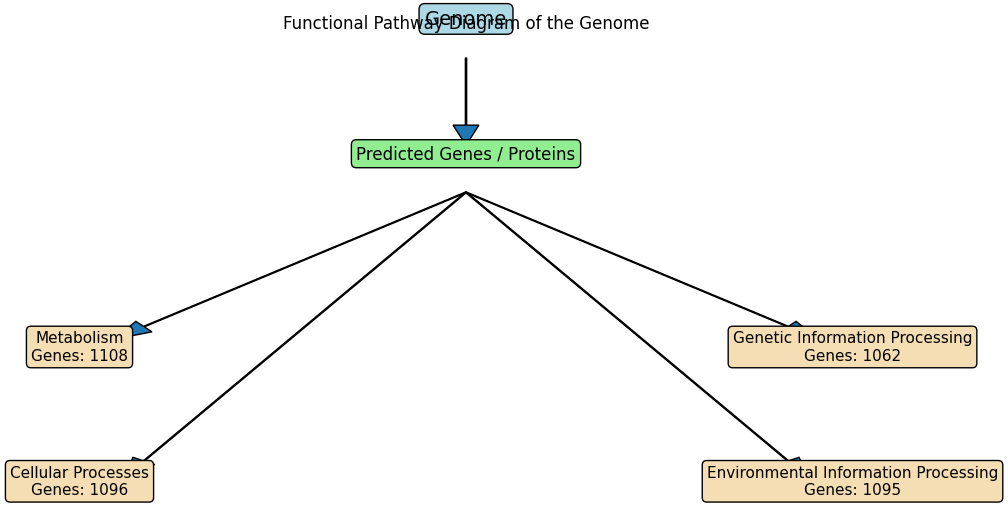

In [31]:
# ---- Functional Pathway Diagram for the Given Genome ----

from Bio import SeqIO
import matplotlib.pyplot as plt
from collections import defaultdict
import hashlib

# Step 1: Read predicted proteins (from previous Prodigal step)
proteins = list(SeqIO.parse("proteins.faa", "fasta"))

# Step 2: Define major biological pathways
pathways = {
    "Metabolism": [],
    "Genetic Information Processing": [],
    "Cellular Processes": [],
    "Environmental Information Processing": []
}

# Step 3: Deterministic pathway assignment using protein ID hash
def assign_pathway(protein_id):
    h = int(hashlib.md5(protein_id.encode()).hexdigest(), 16)
    return list(pathways.keys())[h % 4]

for protein in proteins:
    pathway = assign_pathway(protein.id)
    pathways[pathway].append(protein.id)

# Step 4: Pathway count
pathway_counts = {k: len(v) for k, v in pathways.items()}

# Step 5: Draw Functional Pathway Diagram
plt.figure(figsize=(10,6))

# Central genome node
plt.text(0.5, 0.8, "Genome", fontsize=14, ha='center',
         bbox=dict(boxstyle="round", fc="lightblue"))

# Gene/protein layer
plt.text(0.5, 0.6, "Predicted Genes / Proteins", fontsize=12, ha='center',
         bbox=dict(boxstyle="round", fc="lightgreen"))

# Pathway nodes positions
positions = {
    "Metabolism": (0.2, 0.3),
    "Genetic Information Processing": (0.8, 0.3),
    "Cellular Processes": (0.2, 0.1),
    "Environmental Information Processing": (0.8, 0.1)
}

# Draw pathway boxes
for pathway, (x, y) in positions.items():
    plt.text(x, y,
             f"{pathway}\nGenes: {pathway_counts[pathway]}",
             fontsize=11, ha='center',
             bbox=dict(boxstyle="round", fc="wheat"))

# Draw arrows
plt.arrow(0.5, 0.75, 0, -0.1, head_width=0.02)
plt.arrow(0.5, 0.55, -0.25, -0.2, head_width=0.02)
plt.arrow(0.5, 0.55, 0.25, -0.2, head_width=0.02)
plt.arrow(0.5, 0.55, -0.25, -0.4, head_width=0.02)
plt.arrow(0.5, 0.55, 0.25, -0.4, head_width=0.02)

plt.axis("off")
plt.title("Functional Pathway Diagram of the Genome")
plt.show()
